In [30]:
from models import Ferro, SK, Hopfield, CDMA
import numpy as np
import openjij.cxxjij.system as S
import openjij.cxxjij.utility as U
import openjij.cxxjij.algorithm as A
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy

# 強磁性モデル

In [2]:
N = 512
T_LIM = 30
S_LIM = 21
N_SMPL = 100
N_SKIP = 2000
N_MC = 2000
ferro = Ferro(N, 1/N)

In [17]:
ferro_system = S.make_transverse_ising(ferro.gen_spin(), ferro, 1.0, 4)

temp_list = np.linspace(0.01, 2, T_LIM)
s_list = np.linspace(0, 1, S_LIM)

mm = np.zeros((S_LIM, T_LIM))

# 磁化とその分散を計算
for i, temp in enumerate(temp_list):
    schedule_list = U.make_transverse_field_schedule_list(1/temp, N_SMPL, S_LIM)
    
    mag, mag_std, spins = [], [], []
    idx = 0
    def callback_log(system, t):
        global mag, mag_std, spins, idx
        if idx % 200 == 199:
            spins.append([-1 if np.mean(s)<0 else 1 for s in system.trotter_spins[:-1]])
        if idx % N_SMPL == (N_SMPL-1):
            mag_list = [np.abs(np.mean(state)) for state in spins]
            mag_std.append(np.std(mag_list))
            mag.append(np.mean(mag_list))
            spins = []
        idx = idx + 1
    
    A.Algorithm_SingleSpinFlip_run(ferro_system, schedule_list, callback_log)
    mm[:, i] = mag

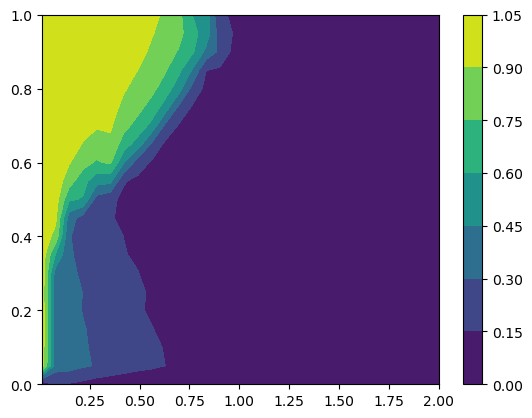

In [ ]:
TT, SS = np.meshgrid(temp_list, s_list)
c = plt.contourf(TT, SS, mm)
plt.colorbar(c)

# CDMA

In [8]:
K = int(N*0.6)
print(K)
cdma = CDMA(N, K, 0)

temp = 0.1
s_list = np.linspace(0, 1, S_LIM)

307
(307,)


In [31]:
cdma_system = S.make_transverse_ising(cdma.gen_spin(), cdma, 1.0, 10)
np.savez_compressed('./results/orgn_signal', cdma.gen_spin())

for idx, s in enumerate(s_list):
    spins = []
    
    # 熱化のためのスキップ
    schedule_list = [((1/temp, s), N_SKIP)]
    A.Algorithm_SingleSpinFlip_run(cdma_system, schedule_list)
    
    for _ in range(N_SMPL):
        schedule_list = [((1/temp, s), N_MC)]
        A.Algorithm_SingleSpinFlip_run(cdma_system, schedule_list)
        spins.append(deepcopy(cdma_system.trotter_spins[:-1]))
        
    filename = './results/s_{:02d}'.format(idx)
    np.savez_compressed(filename, spins)
    print(s)

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


In [41]:
orgn_signal = np.load('./results/orgn_signal.npz')['arr_0']
mag = np.zeros(len(s_list),)
mag_std = np.zeros(len(s_list),)

for idx, s in enumerate(s_list):
    filename = './results/s_{:02d}.npz'.format(idx)
    spins = np.load(filename)['arr_0']
    
    mean_spins = np.mean(spins, axis=2)
    mag_list = mean_spins @ orgn_signal / N
    mag[idx] = np.mean(mag_list)
    mag_std[idx] = np.std(mag_list)

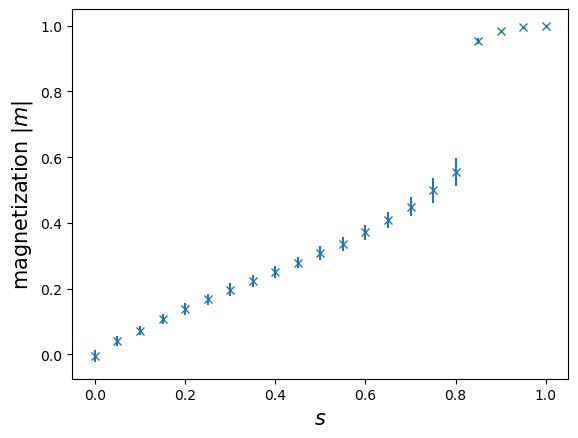

In [48]:
plt.errorbar(s_list, mag, yerr=mag_std, marker='x', linestyle='')
plt.xlabel(r'$s$', fontsize=15)
plt.ylabel(r'magnetization $|m|$', fontsize=15)
plt.show()

In [46]:
overlap = np.zeros(len(s_list),)
overlap_std = np.zeros(len(s_list),)

for idx, s in enumerate(s_list):
    filename = './results/s_{:02d}.npz'.format(idx)
    spins = np.load(filename)['arr_0']
    
    binalized_spins = 2 * (np.mean(spins, axis=2) >= 0) - 1
    overlap_list = binalized_spins @ orgn_signal / N
    overlap[idx] = np.mean(overlap_list)
    overlap_std[idx] = np.std(overlap_list)

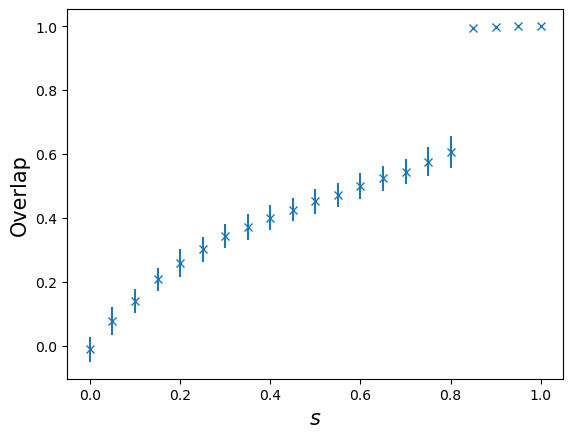

In [49]:
plt.errorbar(s_list, overlap, yerr=overlap_std, marker='x', linestyle='')
plt.xlabel(r'$s$', fontsize=15)
plt.ylabel('Overlap', fontsize=15)
plt.show()